# TMLE Example Notebook

This notebook demonstrates the issue of using uplift curves without knowing true treatment effect and how to solve it by using TMLE as a proxy of the true treatment effect.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
base_path = os.path.abspath("../")
os.chdir(base_path)

In [3]:
import logging
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
import sys
import warnings
warnings.simplefilter("ignore", UserWarning)

from lightgbm import LGBMRegressor

In [7]:
import causalml

from causalml.dataset import synthetic_data
from causalml.inference.meta import BaseXRegressor, TMLELearner
from causalml.metrics.visualize import *
from causalml.propensity import calibrate

print(causalml.__version__)

0.7.0


In [8]:
logger = logging.getLogger('causalml')
logger.setLevel(logging.DEBUG)
plt.style.use('fivethirtyeight')

## Generating Synthetic Data

In [9]:
# Generate synthetic data using mode 1
y, X, treatment, tau, b, e = synthetic_data(mode=1, n=1000000, p=10, sigma=5.)

In [10]:
X_train, X_test, y_train, y_test, e_train, e_test, treatment_train, treatment_test, tau_train, tau_test, b_train, b_test = train_test_split(X, y, e, treatment, tau, b, test_size=0.5, random_state=42)

## Calculating Individual Treatment Effect (ITE/CATE)

In [12]:
# X Learner
learner_x = BaseXRegressor(learner=LGBMRegressor())
learner_x.fit(X=X_train, treatment=treatment_train, y=y_train)
cate_x_test = learner_x.predict(X=X_test, p=e_test, treatment=treatment_test).flatten()

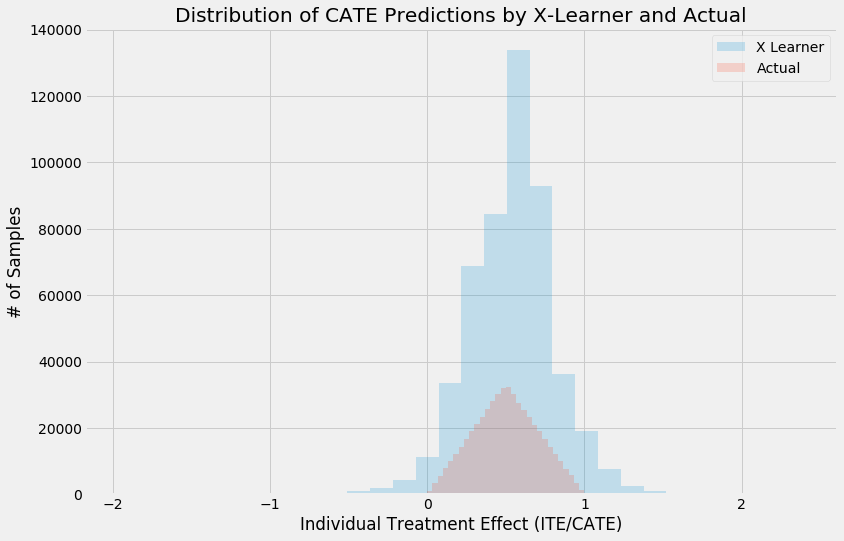

In [13]:
alpha=0.2
bins=30
plt.figure(figsize=(12,8))
plt.hist(cate_x_test, alpha=alpha, bins=bins, label='X Learner')
plt.hist(tau_test, alpha=alpha, bins=bins, label='Actual')

plt.title('Distribution of CATE Predictions by X-Learner and Actual')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')
_=plt.legend()

## Validating CATE without TMLE

In [14]:
df = pd.DataFrame({'y': y_test, 'w': treatment_test, 'tau': tau_test, 'X-Learner': cate_x_test, 'Actual': tau_test})

### Uplift Curve With Ground Truth

If true treatment effect is known as in simulations, the uplift curve of a model uses the cumulative sum of the treatment effect sorted by model's CATE estimate.

In the figure below, the uplift curve of X-learner shows positive lift close to the optimal lift by the ground truth.

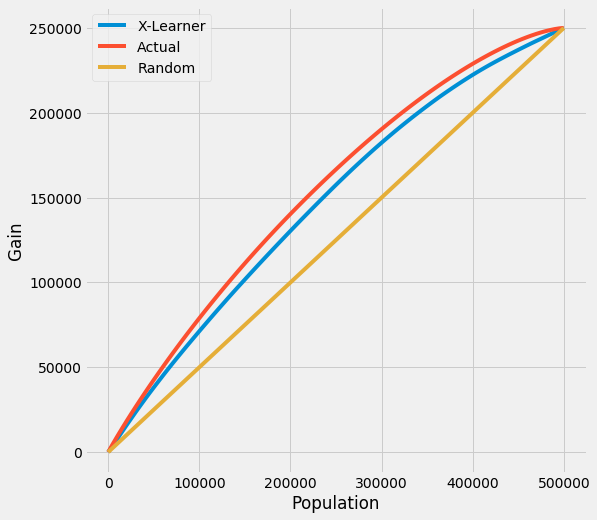

In [15]:
plot(df, outcome_col='y', treatment_col='w', treatment_effect_col='tau')

### Uplift Curve Without Ground Truth

If true treatment effect is unknown as in practice, the uplift curve of a model uses the cumulative mean difference of outcome in the treatment and control group sorted by model's CATE estimate.

In the figure below, the uplift curves of X-learner as well as the ground truth show no lift incorrectly.

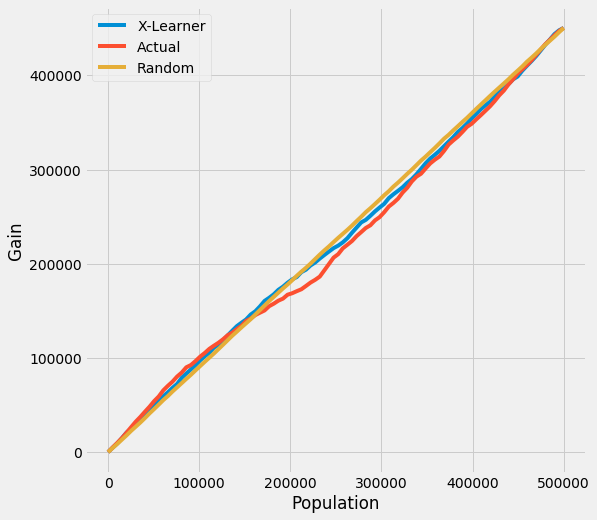

In [16]:
plot(df.drop('tau', axis=1), outcome_col='y', treatment_col='w')

## TMLE 

### Uplift Curve with TMLE as Ground Truth

In [17]:
n_fold = 5
kf = KFold(n_splits=n_fold)

In [18]:
df = pd.DataFrame({'y': y_test, 'w': treatment_test, 'p': e_test, 'X-Learner': cate_x_test, 'Actual': tau_test})

In [19]:
inference_cols = []
for i in range(X_test.shape[1]):
    col = 'col_' + str(i)
    df[col] = X_test[:,i]
    inference_cols.append(col)

In [20]:
df.head()

,y,w,p,X-Learner,Actual,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9
0,6.808806,1,0.750090,0.909261,0.856218,0.911884,0.800551,0.637318,0.584033,0.041204,0.541312,0.183795,0.604942,0.802967,0.321925
1,5.074509,1,0.828351,0.696708,0.613880,0.871032,0.356727,0.168573,0.291071,0.953692,0.838566,0.497353,0.777390,0.811558,0.076717
2,-8.293643,0,0.230920,0.456776,0.335491,0.531401,0.139581,0.604482,0.051055,0.651872,0.878593,0.592694,0.695946,0.972597,0.178291
3,4.511347,0,0.306119,0.189546,0.388202,0.615514,0.160891,0.825520,0.544876,0.107617,0.746920,0.002706,0.963717,0.603323,0.506294
4,5.418169,0,0.293402,0.299151,0.476290,0.839696,0.112883,0.964546,0.336093,0.548355,0.649487,0.905765,0.249261,0.070978,0.947820


In [21]:
tmle_df = get_tmlegain(df, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
                       n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

In [22]:
tmle_df

,X-Learner,Actual,Random
0.0,0.000000,0.000000,0.000000
0.2,0.137463,0.150106,0.095493
0.4,0.254839,0.267014,0.190986
0.6,0.346940,0.359990,0.286479
0.8,0.434913,0.447867,0.381972
1.0,0.477465,0.477465,0.477465


#### Uplift Curve wihtout CI

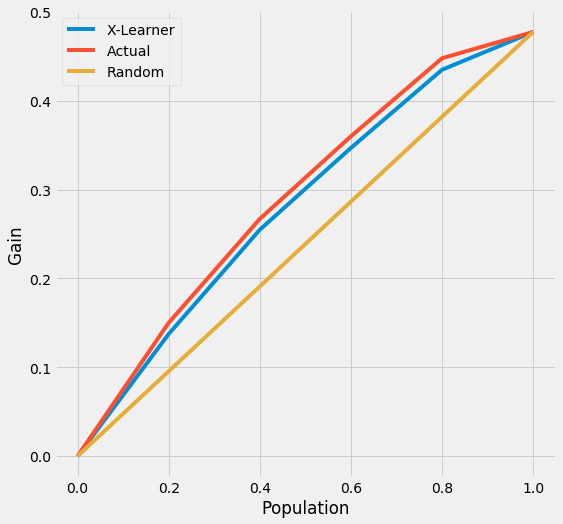

In [23]:
plot_tmlegain(df, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
              n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

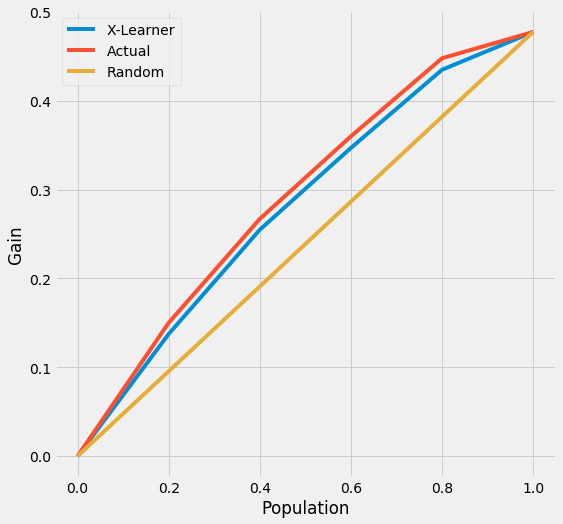

In [24]:
plot(df, kind='gain', tmle=True, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
     n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

#### AUUC Score

In [25]:
auuc_score(df, tmle=True, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
           n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

X-Learner    0.275270
Actual       0.283740
Random       0.238733
dtype: float64

#### Uplift Curve with CI

In [25]:
tmle_df = get_tmlegain(df, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
                       n_segment=5, cv=kf, calibrate_propensity=True, ci=True)

In [26]:
tmle_df

,X-Learner,Actual,X-Learner LB,Actual LB,X-Learner UB,Actual UB,Random
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.2,0.145151,0.146628,0.127016,0.127210,0.163285,0.166046,0.096077
0.4,0.252563,0.255667,0.216629,0.218323,0.288496,0.293011,0.192154
0.6,0.352174,0.364541,0.300866,0.313233,0.403483,0.415850,0.288231
0.8,0.433351,0.446890,0.366285,0.380624,0.500417,0.513157,0.384308
1.0,0.480384,0.480384,0.441999,0.441999,0.518770,0.518770,0.480384


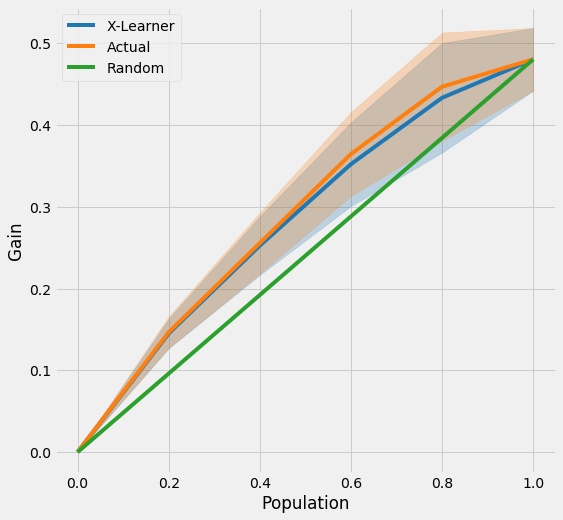

In [27]:
plot_tmlegain(df, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
              n_segment=5, cv=kf, calibrate_propensity=True, ci=True)

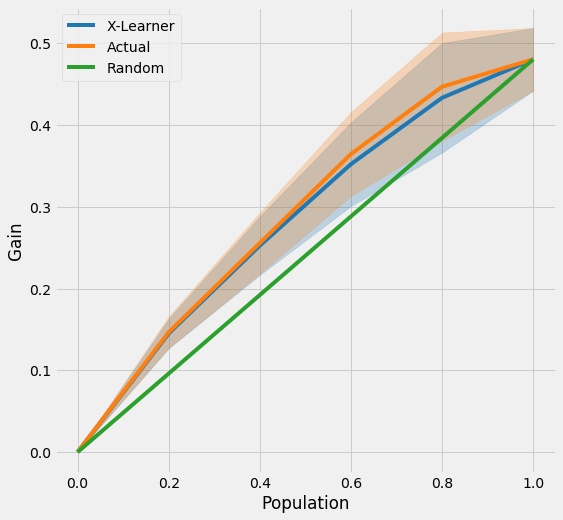

In [29]:
plot(df, kind='gain', tmle=True, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
     n_segment=5, cv=kf, calibrate_propensity=True, ci=True)

### Qini Curve with TMLE as Ground Truth

#### Qini Curve without CI

In [30]:
qini = get_tmleqini(df, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
                    n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

In [31]:
qini

,X-Learner,Actual,Random
0.0,0.000000,0.000000,0.000000
100000.0,53513.373815,59840.329296,24964.329463
200000.0,92693.576894,104578.508000,49928.658925
300000.0,121232.782373,132653.427128,74892.988388
400000.0,136045.083604,145388.277994,99857.317851
500000.0,124821.647313,124821.647313,124821.647313


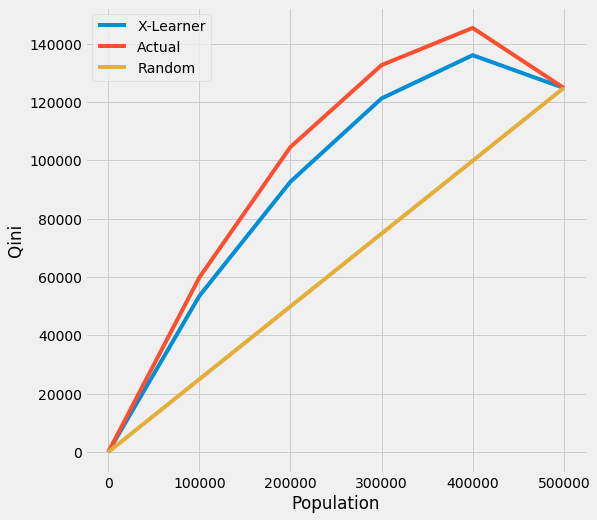

In [32]:
plot_tmleqini(df, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
              n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

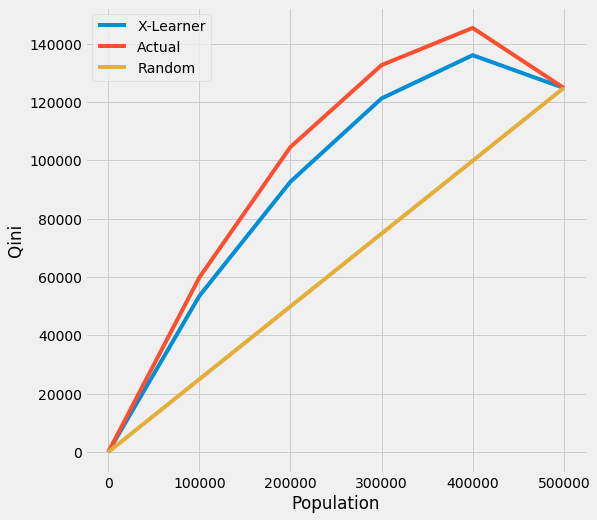

In [34]:
plot(df, kind='qini', tmle=True, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
     n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

#### Qini Score

In [26]:
qini_score(df, tmle=True, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
           n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

X-Learner    23814.998608
Actual       33683.500462
Random           0.000000
dtype: float64

#### Qini Curve with CI

In [36]:
qini = get_tmleqini(df, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
                    n_segment=5, cv=kf, calibrate_propensity=True, ci=True)

In [37]:
qini

,X-Learner,Actual,X-Learner LB,Actual LB,X-Learner UB,Actual UB,Random
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
100000.0,53513.373815,59840.329296,46827.611036,51915.622165,60199.136594,67765.036427,24964.329463
200000.0,92693.576894,104578.508000,79515.426034,89298.783725,105871.727753,119858.232275,49928.658925
300000.0,121232.782373,132653.427128,103649.630931,113772.913012,138815.933816,151533.941243,74892.988388
400000.0,136045.083604,145388.277994,115586.643138,124194.530581,156503.524070,166582.025407,99857.317851
500000.0,124821.647313,124821.647313,124821.647313,124821.647313,124821.647313,124821.647313,124821.647313


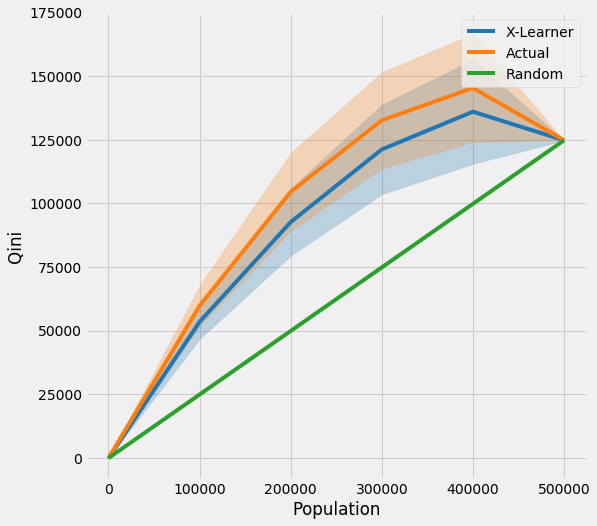

In [38]:
plot_tmleqini(df, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
              n_segment=5, cv=kf, calibrate_propensity=True, ci=True)

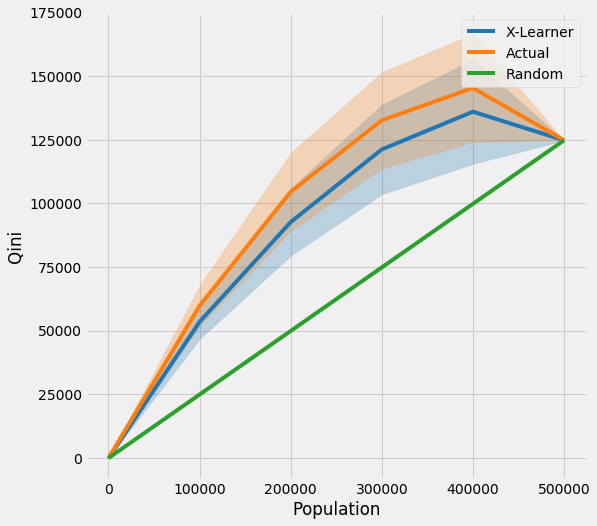

In [39]:
plot(df, kind='qini', tmle=True, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
     n_segment=5, cv=kf, calibrate_propensity=True, ci=True)